In [1]:
from text_adventure_games import (
    games, parsing, actions, things, blocks, viz
)
from collections import defaultdict

# Locations

In [2]:
farmhouse = things.Location(
    "Farmhouse",
    "You are in a small farmhouse."
)
kitchen = things.Location(
    "Kitchen",
    "You are in a kitchen. There is a stove."
)
farm = things.Location(
    "Farm",
    "You are on a farm. There is a farmhouse, barn, field, and toolshed here."
)
barn = things.Location(
    "Barn",
    "You are in a large barn. There are animals here and their feed."
)
field = things.Location(
    "Field",
    "You are in a field. There are a variety of crops growing here."
)
toolshed = things.Location(
    "Toolshed",
    "You are in a toolshed. There are various tools and equipment here."
)

# Map of locations
farmhouse.add_connection("left", kitchen)
kitchen.add_connection("right", farmhouse)
farm.add_connection("in", farmhouse)
farm.add_connection("west", barn)
farm.add_connection("south", field)
field.add_connection("west", toolshed)


# 

# Game Map

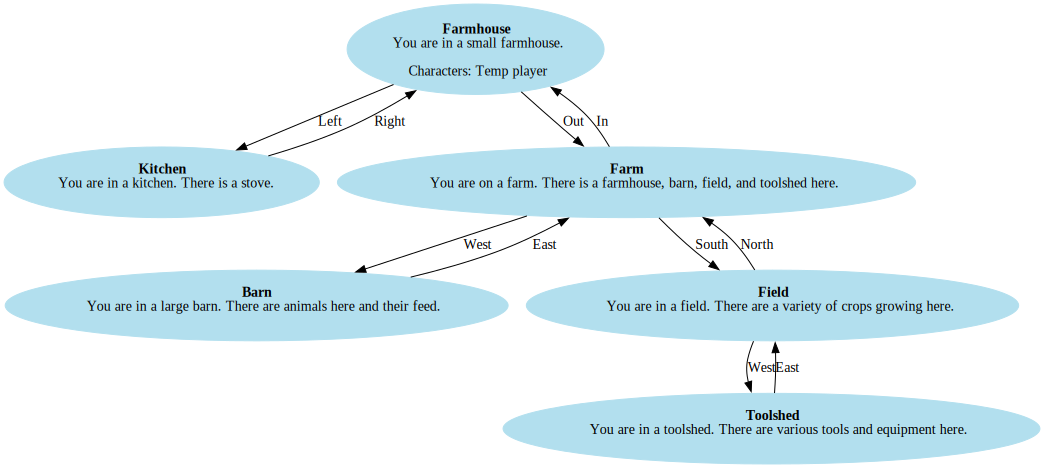

In [3]:
tempgame = games.Game(farmhouse, things.Character(name="Temp Player", description="", persona=""))

from text_adventure_games.viz import Visualizer
viz = Visualizer(tempgame)
graph = viz.visualize()
graph

# Items

## Gettable Items

In [4]:
# Farmhouse items
key = things.Item(
    "key",
    "key",
    "A RUSTY KEY",
)
key.set_property("gettable", True)
farmhouse.add_item(key)

# Barn items
egg = things.Item(
    "egg",
    "egg",
)
egg.set_property("gettable", True)
milk_bucket = things.Item(
    "bucket",
    "bucket",
    "AN IRON BUCKET TO HOLD MILK.",
)
milk_bucket.set_property("gettable", True)
barn.add_item(egg)
barn.add_item(milk_bucket)

# Toolshed items
scythe = things.Item(
    "scythe",
    "scythe",
    "A SLIGHTLY WORN SCYTHE USED FOR CUTTING CROPS.",
)
scythe.set_property("gettable", True)
toolshed.add_item(scythe)

## Scenery Items

In [ ]:
# Kitchen items
refrigerator = things.Item(
    "refrigerator",
    "A refrigerator used for storing food.",
)
refrigerator.set_property("gettable", False)
refrigerator.set_property("empty", False)
refrigerator.add_command_hint("retrieve bacon from refrigerator")

stove = things.Item(
    "stove",
    "A stove used for cooking.",
    "A STOVE WITH A PAN ON IT.",
)
stove.set_property("gettable", False)
stove.set_property("is_lit", False)
stove.add_command_hint("toggle stove")
stove.add_command_hint("cook breakfast")

kitchen.add_item(refrigerator)
kitchen.add_item(stove)

# Field items
sprinkler_knob = things.Item(
    "sprinklerknob",
    "A knob that controls the sprinkler system.",
)
sprinkler_knob.set_property("gettable", False)
sprinkler_knob.set_property("turnable", True)
sprinkler_knob.set_property("on", False)
sprinkler_knob.add_command_hint("turn sprinkler knob")

wheat_field = things.Item(
    "crops",
    "Stalks of wheat.",
)
wheat_field.set_property("gettable", False)
wheat_field.set_property("harvestable", False)
wheat_field.add_command_hint("harvest crops")

door = things.Item(
    "door",
    "A door to the toolshed.",
)
door.set_property("gettable", False)
door.set_property("locked", True)
door.add_command_hint("unlock door")

field.add_item(sprinkler_knob)
field.add_item(wheat_field)
field.add_item(door)

# Characters

In [ ]:
player = things.Character(
    name="The Player",
    description="You are a hungry farmer looking for breakfast.",
    persona="I am a farmer gathering ingredients for breakfast.",
)

chef = things.Character(
    name="chef",
    description="A chef controlling entrance to the kitchen.",
    persona="I am a chef who won't allow people who have no business in the kitchen to enter."
)
chef.set_property("satisfied", False)
chef.set_property("character_type", "human")
chef.add_command_hint("show ingredients")
farmhouse.add_character(chef)

cow = things.Character(
    name="cow",
    description="A cow that is mooing.",
    persona="I am a cow."
)
cow.set_property("milkable", False)
cow.set_property("character_type", "animal")
cow.add_command_hint("milk cow")
barn.add_character(cow)

milk = things.Item(
    "milk",
    "Fresh milk from a cow.",
    "A FRESH BUCKET OF MILK.",
)
cow.add_to_inventory(milk)

# Actions

In [ ]:
class Turn_Sprinkler_Knob(actions.Action):
    ACTION_NAME = "turn sprinkler knob"
    ACTION_DESCRIPTION = "Turn the sprinkler knob to turn the sprinkler on or off."
    ACTION_ALIASES = ["turn sprinkler", "turn knob", "toggle sprinkler"]

    def __init__(self, game, command):
        super().__init__(game)
        self.player = game.player
        self.sprinkler_knob = self.parser.match_item(
            "sprinklerknob", self.parser.get_items_in_scope(self.player)
        )

    def check_preconditions(self):
        if not self.sprinkler_knob:
            self.parser.fail("You don't see a sprinkler knob here.")
            return False
        if not self.sprinkler_knob.get_property("turnable"):
            self.parser.fail("You can't turn that.")
            return False
        return True
    
    def apply_effects(self):
        if self.sprinkler_knob.get_property("used"):
            self.parser.fail("You broke the knob!")
            self.player.set_property("failed", True)
            return
        if self.sprinkler_knob.get_property("on"):
            self.sprinkler_knob.set_property("on", False)
            self.sprinkler_knob.set_property("turnable", False)
            self.sprinkler_knob.set_property("used", True)
            self.parser.ok("You turn the sprinkler off.")
        else:
            self.sprinkler_knob.set_property("on", True)
            crops = self.parser.match_item(
                "crops", self.parser.get_items_in_scope(self.player)
            )
            crops.set_property("harvestable", True)
            self.parser.ok("You turn the sprinkler on. Like magic, the crops start to grow!")

class Harvest_Wheat(actions.Action):
    ACTION_NAME = "harvest crops"
    ACTION_DESCRIPTION = "Harvest the wheat from the field."
    ACTION_ALIASES = ["cut crops", "pick crops"]

    def __init__(self, game, command):
        super().__init__(game)
        self.player = game.player
        self.scythe = self.player.inventory.get("scythe", None)
        self.crops = self.parser.match_item(
            "crops", self.parser.get_items_in_scope(self.player)
        )
        self.sprinkler_knob = self.parser.match_item(
            "sprinklerknob", self.parser.get_items_in_scope(self.player)
        )

    def check_preconditions(self):
        if not self.crops:
            self.parser.fail("You don't see any wheat here.")
            return False
        if not self.crops.get_property("harvestable"):
            self.parser.fail("You can't harvest that.")
            return False
        if not self.scythe:
            self.parser.fail("You don't have the right tools.")
            return False
        if self.sprinkler_knob.get_property("on"):
            self.parser.fail("You're wet and cold from the sprinkler. You feel ill.")
            self.player.set_property("failed", True)
            return False
        return True
    
    def apply_effects(self):
        self.crops.set_property("harvestable", False)
        wheat = things.Item(
            "wheat",
            "Freshly harvested wheat.",
            "A BUNDLE OF FRESHLY HARVESTED WHEAT.",
        )
        self.player.add_to_inventory(wheat)
        self.parser.ok("You harvest the wheat and add it to your inventory.")

class Unlock_Door(actions.Action):
    ACTION_NAME = "unlock door"
    ACTION_DESCRIPTION = "Unlock the door to the toolshed."
    ACTION_ALIASES = ["unlock toolshed", "open door", "open toolshed"]

    def __init__(self, game, command):
        super().__init__(game)
        self.player = game.player
        self.door = self.parser.match_item(
            "door", self.parser.get_items_in_scope(self.player)
        )
        self.key = self.player.inventory.get("key", None)

    def check_preconditions(self):
        if not self.door:
            self.parser.fail("You don't see a door here.")
            return False
        if not self.door.get_property("locked"):
            self.parser.fail("The door is already unlocked.")
            return False
        if not self.key:
            self.parser.fail("You don't have the right key.")
            return False
        return True
    
    def apply_effects(self):
        self.door.set_property("locked", False)
        self.player.remove_from_inventory(self.key)
        self.parser.ok("You unlock the door with the key.")

class Feed_Cow(actions.Action):
    ACTION_NAME = "feed cow"
    ACTION_DESCRIPTION = "Feed the cow some wheat."
    ACTION_ALIASES = []

    def __init__(self, game, command):
        super().__init__(game)
        self.player = game.player
        self.cow = self.parser.get_character("cow")
        self.wheat = self.player.inventory.get("wheat", None)
    
    def check_preconditions(self):
        if not self.cow.location == self.player.location:
            self.parser.fail("You don't see a cow here.")
            return False
        if not self.wheat:
            self.parser.fail("You don't have any wheat to feed the cow.")
            return False
        return True

    def apply_effects(self):
        self.player.remove_from_inventory(self.wheat)
        self.cow.set_property("milkable", True)
        self.parser.ok("You feed the cow some wheat. It seems happy and ready to be milked.")

class Milk_Cow(actions.Action):
    ACTION_NAME = "milk cow"
    ACTION_DESCRIPTION = "Milk the cow."
    ACTION_ALIASES = ["get milk", "milk"]

    def __init__(self, game, command):
        super().__init__(game)
        self.player = game.player
        self.cow = self.parser.get_character("cow")
        self.milk_bucket = self.player.inventory.get("bucket", None)

    def check_preconditions(self):
        if not self.cow.location == self.player.location:
            self.parser.fail("You don't see a cow here.")
            return False
        if not self.cow.get_property("milkable"):
            self.parser.fail("The cow gets mad and kicks you. You spill the milk on the ground.")
            self.player.set_property("failed", True)
            return False
        if not self.milk_bucket:
            self.parser.fail("You don't have a container for the milk.")
            return False
        return True
    
    def apply_effects(self):
        milk = self.cow.inventory.get("milk", None)
        if milk:
            self.player.remove_from_inventory(self.milk_bucket)
            self.player.add_to_inventory(milk)
            self.cow.remove_from_inventory(milk)
            self.parser.ok("You milk the cow and obtain some milk.")

class Show_Ingredients(actions.Action):
    ACTION_NAME = "show ingredients"
    ACTION_DESCRIPTION = "Show the chef your ingredients for breakfast."
    ACTION_ALIASES = ["show chef ingredients", "show chef breakfast ingredients"]

    def __init__(self, game, command):
        super().__init__(game)
        self.player = game.player
        self.chef = self.parser.get_character("chef")
        self.milk = self.player.inventory.get("milk", None)
        self.egg = self.player.inventory.get("egg", None)
    
    def check_preconditions(self):
        if not self.chef.location == self.player.location:
            self.parser.fail("You don't see the chef here.")
            return False
        if not self.milk or not self.egg:
            self.parser.fail("You don't have all the ingredients for breakfast.")
            return False
        return True

    def apply_effects(self):
        self.chef.set_property("satisfied", True)
        self.parser.ok("You show the chef your ingredients. He is satisfied and allows you to enter the kitchen.")

class Get_Bacon(actions.Action):
    ACTION_NAME = "retrieve bacon from refrigerator"
    ACTION_DESCRIPTION = "Get the bacon from the refrigerator."
    ACTION_ALIASES = ["take bacon", "get bacon from refrigerator", "take bacon from refrigerator"]

    def __init__(self, game, command):
        super().__init__(game)
        self.player = game.player
        self.refrigerator = self.parser.match_item(
            "refrigerator", self.parser.get_items_in_scope(self.player)
        )
    
    def check_preconditions(self):
        if not self.refrigerator.location == self.player.location:
            self.parser.fail("You don't see a refrigerator here.")
            return False
        if refrigerator.get_property("empty"):
            self.parser.fail("There's nothing in the refrigerator.")
            return False
        return True
    
    def apply_effects(self):
        bacon = things.Item(
            "bacon",
            "A strip of bacon.",
            "A STRIP OF BACON.",
        )
        self.player.add_to_inventory(bacon)
        self.refrigerator.set_property("empty", True)
        self.parser.ok("You take the bacon from the refrigerator.")

class Toggle_Stove(actions.Action):
    ACTION_NAME = "toggle stove"
    ACTION_DESCRIPTION = "Toggle the stove on or off."
    ACTION_ALIASES = []

    def __init__(self, game, command):
        super().__init__(game)
        self.player = game.player
        self.stove = self.parser.match_item(
            "stove", self.parser.get_items_in_scope(self.player)
        )
    
    def check_preconditions(self):
        if not self.stove:
            self.parser.fail("You don't see a stove here.")
            return False
        return True
    
    def apply_effects(self):
        if self.stove.get_property("is_lit"):
            self.stove.set_property("is_lit", False)
            self.parser.ok("You turn the stove off.")
        else:
            self.stove.set_property("is_lit", True)
            self.parser.ok("You turn the stove on.")

class Cook_Breakfast(actions.Action):
    ACTION_NAME = "cook breakfast"
    ACTION_DESCRIPTION = "Cook breakfast using the ingredients."
    ACTION_ALIASES = ["make breakfast", "prepare breakfast"]

    def __init__(self, game, command):
        super().__init__(game)
        self.player = game.player
        self.stove = self.parser.match_item(
            "stove", self.parser.get_items_in_scope(self.player)
        )
        self.bacon = self.player.inventory.get("bacon", None)
    
    def check_preconditions(self):
        if not self.stove.location == self.player.location:
            self.parser.fail("You don't see a stove here.")
            return False
        if not self.stove.get_property("is_lit"):
            self.parser.fail("The stove is not lit.")
            return False
        if not self.bacon:
            self.parser.fail("You don't have any bacon to complete your breakfast.")
            return False
        return True
    
    def apply_effects(self):
        breakfast = things.Item(
            "breakfast",
            "Bacon, eggs, and milk.",
            "DELICIOUS BREAKFAST.",
        )

        self.player.add_to_inventory(breakfast)
        self.parser.ok("You cook the bacon on the stove and prepare a delicious breakfast.")

# Blocks

In [8]:
class DoorBlock(blocks.Block):
    '''
    Blocks entering the toolshed until the door is unlocked.
    '''

    def __init__(self, location: things.Location, door: things.Item):
        super().__init__(
            "The door is locked.",
            "You need to unlock the door before you can enter.",
        )
        self.location = location
        self.door = door
    
    def is_blocked(self) -> bool:
        if self.door:
            if self.location != self.door.location:
                return False
            if self.door.get_property("locked"):
                return True
        return False
    
class ChefBlock(blocks.Block):
    '''
    Blocks entering kitchen until player has other ingredients.
    '''

    def __init__(self, location: things.Location, chef: things.Character):
        super().__init__(
            "A chef blocks your way.",
            "You need to get all ingredients to make breakfast.",
        )
        self.location = location
        self.chef = chef
    
    def is_blocked(self) -> bool:
        if self.chef:
            if self.location != self.chef.location:
                print(self.location.description)
                print(self.chef.location.description)
                return False
            if not self.chef.get_property("satisfied"):
                return True
        return False

In [9]:
door_block = DoorBlock(field, door)
field.add_block("west", door_block)

chef_block = ChefBlock(farmhouse, chef)
farmhouse.add_block("left", chef_block)

In [ ]:
class FarmBreakfast(games.Game):
    def __init__(self, start_at: things.Location, player: things.Character, characters=None, custom_actions=None):
        super().__init__(start_at, player, characters=characters, custom_actions=custom_actions)
    def is_won(self):
        if self.player.inventory.get("breakfast", None):
            print("You have made breakfast!")
            print("You win!")
            return True
        if self.player.get_property("failed"):
            print("You have failed to make breakfast.")
            print("GAME OVER!")
            return True
        return False

In [11]:
characters = [chef, cow]
custom_actions = [Turn_Sprinkler_Knob, Harvest_Wheat, Unlock_Door, Feed_Cow, Milk_Cow, Show_Ingredients, Get_Bacon, Toggle_Stove, Cook_Breakfast]

game = FarmBreakfast(start_at=farmhouse, player=player, characters=characters, custom_actions=custom_actions)

In [12]:
game.game_loop()

You are in a small farmhouse.
Exits:
Left to Kitchen
Out to Farm

You see:
 * key
Characters:
 *
 * A chef controlling entrance to the kitchen.

You don't have all the ingredients for breakfast.
The Player got the key.
You are on a farm. There is a farmhouse, barn, field, and toolshed here.
Exits:
In to Farmhouse
West to Barn
South to Field




You are in a large barn. There are animals here and their feed.
Exits:
East to Farm

You see:
 * egg
 * bucket
Characters:
 * A cow that is mooing.

You are on a farm. There is a farmhouse, barn, field, and toolshed here.
Exits:
In to Farmhouse
West to Barn
South to Field




You are in a field. There are a variety of crops growing here.
Exits:
North to Farm
West to Toolshed

You see:
 * A knob that controls the sprinkler system.
        turn sprinkler knob
 * Stalks of wheat.
        harvest crops
 * A door to the toolshed.
        unlock door


You unlock the door with the key.
You are in a toolshed. There are various tools and equipment here.